<a href="https://colab.research.google.com/github/abhicoder007/agrigenomics/blob/main/lungdiesease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Aug  8 14:05:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle competitions download -c multilabel-bird-species-classification-nips2013
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types

100% 2.02G/2.02G [01:47<00:00, 22.6MB/s]
100% 2.02G/2.02G [01:47<00:00, 20.3MB/s]


In [ ]:
! unzip lungs-disease-dataset-4-types.zip

Streaming output truncated to the last 5000 lines.
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0673-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0675-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0678-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0680-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0682-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0683-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0684-0001-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0686-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0690-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0692-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0693-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0695-0001.jpeg  
  inflating: Lung Disease Dataset/train/Norm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import Xception
# import tensorflow.keras.models.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from glob import glob
from keras.models import Sequential

In [ ]:
train_path = "/content/Lung Disease Dataset/train"
test_path = "/content/Lung Disease Dataset/test"
validation_path = "/content/Lung Disease Dataset/val"

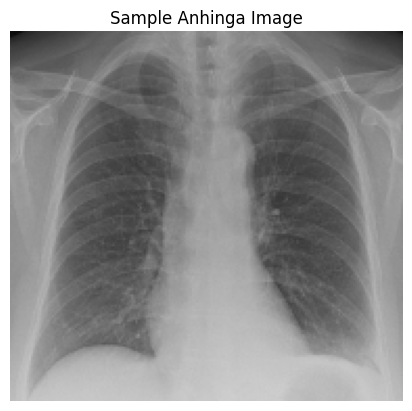

In [ ]:
img = load_img("/content/Lung Disease Dataset/test/Corona Virus Disease/00030346_007.png")
plt.imshow(img)
plt.axis("off")
plt.title("Sample Anhinga Image")
plt.show()

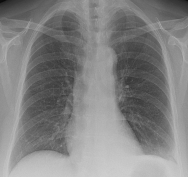

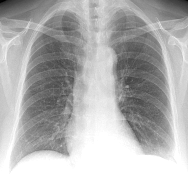

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
kernel_size = 40 # Adjust the kernel size based on your requirements
noise_var = 0.1# Adjust this value based on the noise level in your images

# Function to perform contrast adjustment on the input image
def contrast_adjustment(image):
    adjusted_image = cv2.normalize(image, None, alpha=0, beta=290,norm_type=cv2.NORM_MINMAX)
    # cv2_imshow(adjusted_image)
    return adjusted_image
    # return wiener_filter(adjusted_image, kernel_size, noise_var)

# Function to apply Wiener filtering on the input image
def wiener_filter(image, kernel_size, noise_var):
    psf = np.ones((kernel_size, kernel_size)) / kernel_size**2
    filtered_image = cv2.filter2D(image, -1, psf)
    noise_estimation = np.var(image - filtered_image)
    wiener_filter = 1 - (noise_var / noise_estimation)
    filtered_image = np.clip(image + wiener_filter * (filtered_image - image), 0, 255)

    return filtered_image

# Load the grayscale X-ray image
x = cv2.imread('/content/Lung Disease Dataset/test/Corona Virus Disease/00030346_007.png', cv2.IMREAD_GRAYSCALE)

# Perform contrast adjustment
x1 = contrast_adjustment(x)

# Apply Wiener filtering

x2 = wiener_filter(x1, kernel_size, noise_var)

# Display the original, contrast-adjusted, and Wiener-filtered images
cv2_imshow(x)
cv2_imshow(x1)
# plt.imshow(x2)
# plt.imshow(x2)
# print(x.shape)

# Wait for a key press and then close the windows
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import os
fileList=os.listdir(train_path)
total_images=0
for i in fileList:
  total_images1=len(os.listdir(train_path+"/"+i))
  total_images+=len(os.listdir(train_path+"/"+i))
  print(total_images1,i)
total_images

1207 Normal
1220 Tuberculosis
1218 Corona Virus Disease
1204 Viral Pneumonia
1205 Bacterial Pneumonia


6054

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
batch_size = 64
train_datagen = ImageDataGenerator(
     preprocessing_function=lambda img: contrast_adjustment(img),

        #            shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True,
        # rotation_range=20,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        #            rescale=1.0/255.0
    #  samplewise_center=True,
    #                           samplewise_std_normalization=True,
    #                           horizontal_flip = True,
    #                           vertical_flip = False,
                              # height_shift_range= 0.01,
                              # width_shift_range=0.01,
                              # rotation_range=1,
    #                           shear_range = 0.1,
    #                           fill_mode = 'reflect',
                              # zoom_range=0.15,
    #  rescale=1.0/255.0
     #modified -----
      rescale=1.0/255.0,
     vertical_flip = True,
    brightness_range=(0.8, 1.2),
     rotation_range=40,
    # preprocessing_function=lambda img: add_gaussian_noise(img),
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
                  )
val_datagen =ImageDataGenerator(
     preprocessing_function=lambda img: contrast_adjustment(img),
    #  preprocessing_function=lambda img: apply_blue_green_filter(img),
                   rescale=1.0/255.0
                  )
def apply_blue_green_filter(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_img[:, :, 0] = 120  # Set hue channel to 120 for green
    hsv_img[:, :, 1] = 255  # Set saturation channel to maximum value
    hsv_img[:, :, 2] = 255  # Set value channel to maximum value
    filtered_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return filtered_img

train_generator = train_datagen.flow_from_directory(
                train_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical",
                # subset='training'

                )

val_generator = val_datagen.flow_from_directory(
                validation_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical",
                # subset = 'validation'
                )

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.


In [ ]:
# base_model = NASNetLarge(include_top=False)
import json
# base_model = mobilenet_v2(include_top=False)
base_model = Xception(weights="imagenet",include_top=False)

# 2. Freezing The Base Model
# base_model.trainable = False
base_model.trainable = True

# 3. Creating Inputs Into Our Model
inputs = tf.keras.layers.Input(shape=(224 ,224, 3), name='InputLayer')

# 4. Passing The Inputs To The Base Model
x = base_model(inputs)
#batchnorm
x = BatchNormalization()(x)

# 5. Average Pooling The Outputs Of The Base Model
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)
x=tf.keras.layers.Dropout(0.5)(x);
# 6. Creating The Output Activation Layer
outputs = tf.keras.layers.Dense(5, activation='softmax', name='OutputLayer')(x)

# 7. Combining The Inputs With The Outputs Into A Model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compiling The Model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])
# 9. Fitting The Model
# model_0.optimizer.optimizer_specs[0]["optimizer"].get_config()["weight_decay"]

# <tf.Tensor: shape=(), dtype=float32, numpy=1.0000001e-05>
from tensorflow.keras.callbacks import ReduceLROnPlateau
Checkpoint = tf.keras.callbacks.ModelCheckpoint("xception.hdf5", monitor="val_accuracy", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_accuracy", factor= 0.5, patience= 3, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)
#model summary
model_0.summary()
history_0 = model_0.fit_generator(train_generator,
                       epochs=20,
                       steps_per_epoch=train_generator.samples//batch_size,
                                   callbacks= [reduce_lr,Checkpoint],
                       validation_data=val_generator,
                       validation_steps=val_generator.samples // batch_size)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 batch_normalization_34 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 GlobalAveragePoolingLayer (  (None, 2048)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 OutputLayer (Dense)         (None, 5)                 1024

<ipython-input-25-7b35b4baa5bb>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_0 = model_0.fit_generator(train_generator,


Epoch 1/20
94/94 [==============================] - 296s 2s/step - loss: 0.5646 - accuracy: 0.7738 - val_loss: 0.8924 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 224s 2s/step - loss: 0.3751 - accuracy: 0.8513 - val_loss: 0.6122 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 235s 3s/step - loss: 0.3444 - accuracy: 0.8524 - val_loss: 1.3360 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 222s 2s/step - loss: 0.3021 - accuracy: 0.8818 - val_loss: 0.7763 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8835
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 [==============================] - 236s 3s/step - loss: 0.2960 - accuracy: 0.8835 - val_loss: 0.9248 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - 222s 2s/step - loss

In [ ]:
model_0.save("/content/my_model.h5")

In [ ]:
#finr tunning
# Unfreezing All Of The Layers In The Base Model
base_model.trainable = True

# Refreezing Every Layer Except The Last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])
Checkpoint = tf.keras.callbacks.ModelCheckpoint("densenet201.hdf5", monitor="val_accuracy", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_accuracy", factor= 0.5, patience= 1, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.000001)

In [ ]:
initial_epochs = 20
model_0.summary()
# Fine Tuning For Another 5 Epochs
fine_tune_epochs = initial_epochs + 5

# Refitting The Model
history_data_aug_fine_tuned = model_0.fit_generator(train_generator,
                                steps_per_epoch=train_generator.samples//batch_size,
                                 epochs=fine_tune_epochs,
                                           callbacks= [ reduce_lr,Checkpoint],
                                 validation_data=val_generator,
                                 validation_steps=val_generator.samples//batch_size,
                                 initial_epoch=history_0.epoch[-1]
                                                    )

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 batch_normalization_44 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 GlobalAveragePoolingLayer (  (None, 2048)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 OutputLayer (Dense)         (None, 5)                 1024

<ipython-input-38-66b4ddc7f923>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_data_aug_fine_tuned = model_0.fit_generator(train_generator,


Epoch 20/25
94/94 [==============================] - 167s 2s/step - loss: 0.0596 - accuracy: 0.9778 - val_loss: 0.3851 - val_accuracy: 0.9017 - lr: 1.0000e-05
Epoch 21/25
94/94 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9800
Epoch 21: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
94/94 [==============================] - 154s 2s/step - loss: 0.0531 - accuracy: 0.9800 - val_loss: 0.3854 - val_accuracy: 0.9002 - lr: 1.0000e-05
Epoch 22/25
94/94 [==============================] - 174s 2s/step - loss: 0.0586 - accuracy: 0.9781 - val_loss: 0.3849 - val_accuracy: 0.8972 - lr: 5.0000e-06
Epoch 23/25
94/94 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9793
Epoch 23: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
94/94 [==============================] - 152s 2s/step - loss: 0.0555 - accuracy: 0.9793 - val_loss: 0.3925 - val_accuracy: 0.8972 - lr: 5.0000e-06
Epoch 24/25
33/94 [=========>...............

In [ ]:
from keras import models
#ensemble two models densenet and xception
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.layers import Input,Average


model_1=load_model("/content/drive/MyDrive/sample_data/densenet201 (3).hdf5")
model_2=load_model("/content/xception.hdf5")
Checkpoint = tf.keras.callbacks.ModelCheckpoint("ensemble.hdf5", monitor="val_accuracy", save_best_only= True, mode="max")
model_1=Model(inputs=model_1.inputs,outputs=model_1.outputs)
model_2=Model(inputs=model_2.inputs,outputs=model_2.outputs)
models=[model_1,model_2]
m=Input(shape=(224,224,3))
mo=[model(m) for model in models]
eo=Average()(mo)
emodel=Model(inputs=m,outputs=eo,name="ensemle")






In [ ]:
emodel.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
md = emodel.fit_generator(train_generator,
                       epochs=5,
                       steps_per_epoch=train_generator.samples//batch_size,
                                  #  callbacks= [Checkpoint],
                       validation_data=val_generator,
                       validation_steps=val_generator.samples // batch_size)

<ipython-input-30-666083a66c9a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  md = emodel.fit_generator(train_generator,


Epoch 1/5
189/189 [==============================] - 158s 838ms/step - loss: 0.3895 - accuracy: 0.8481 - val_loss: 0.4359 - val_accuracy: 0.8284
Epoch 2/5
189/189 [==============================] - 155s 823ms/step - loss: 0.3766 - accuracy: 0.8549 - val_loss: 0.4378 - val_accuracy: 0.8294
Epoch 3/5
189/189 [==============================] - 161s 850ms/step - loss: 0.3713 - accuracy: 0.8555 - val_loss: 0.4730 - val_accuracy: 0.7927
Epoch 4/5
189/189 [==============================] - 159s 842ms/step - loss: 0.3563 - accuracy: 0.8600 - val_loss: 0.4145 - val_accuracy: 0.8343
Epoch 5/5
189/189 [==============================] - 159s 841ms/step - loss: 0.3487 - accuracy: 0.8660 - val_loss: 0.4217 - val_accuracy: 0.8289


In [ ]:
#loading a prviouse model and training it everyday
from tensorflow.keras.models import load_model
prev_model=load_model("/content/my_model.h5")
prev_model.summary()
history_0 = prev_model.fit_generator(train_generator,
                       epochs=2,
                       steps_per_epoch=train_generator.samples//batch_size,
                                   callbacks= [reduce_lr,Checkpoint],
                       validation_data=val_generator,
                       validation_steps=val_generator.samples // batch_size)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 GlobalAveragePoolingLayer (  (None, 1536)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 OutputLayer (Dense)         (None, 5)                 7685      
                                                                 
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
_________________________________________________________________


<ipython-input-44-e0658a75658d>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_0 = prev_model.fit_generator(train_generator,


Epoch 1/2
189/189 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7667

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.models import load_model
prev_model=load_model("/content/xception.hdf5")
prev_model.summary()
test_data = val_datagen.flow_from_directory(
                test_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )
prev_model.evaluate(test_data)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 batch_normalization_34 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 GlobalAveragePoolingLayer (  (None, 2048)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 OutputLayer (Dense)         (None, 5)                 1024

[0.332770973443985, 0.8972839713096619]

In [ ]:
class_map = train_generator.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)
print(classes)

['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming you have 'model_0' trained and test data prepared
true_labels=[]
import os
fileList=os.listdir(test_path)
k=0
total_images=0
for i in fileList:
  for j in os.listdir(test_path+"/"+i):
    true_labels.append(k)
  k+=1
predictions = model_0.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
print(predicted_labels)
print(true_labels)
# true_labels = np.argmax(classes, axis=0)  # Convert one-hot encoded true labels to class labels

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)


Accuracy: 0.1980246913580247


In [ ]:
from tensorflow.keras.preprocessing import image
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    print(prediction[0][index]*100)

    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 46ms/step
56.15978240966797


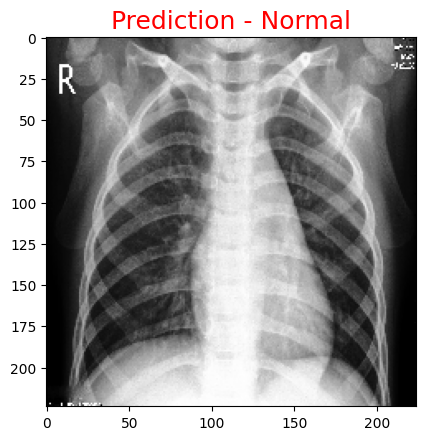

In [ ]:
predict_image("/content/Lung Disease Dataset/val/Viral Pneumonia/018.jpeg", emodel)

1/1 [==============================] - 0s 206ms/step
89.96021747589111


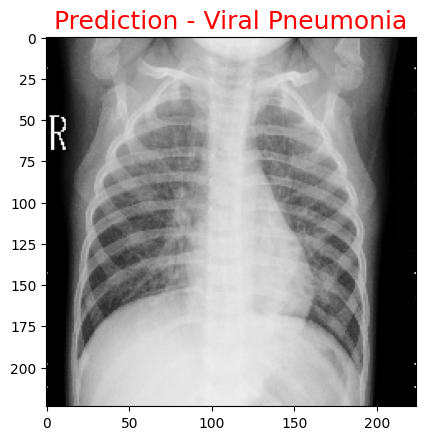

In [ ]:
predict_image("/content/Lung Disease Dataset/test/Viral Pneumonia/VIRUS-1753514-0003.jpeg", emodel)